# Deliverable 3: Classification, Clustering, and Pattern Mining
**MSCS 634 Project – Jacob Jeffers**

This notebook includes three main tasks:
1. Classification using machine learning models
2. Clustering to identify groupings in the data
3. Association rule mining to find interesting patterns

The dataset is the same cleaned powerlifting data from Deliverables 1 and 2.


In [1]:
# Standard Python libraries for data work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for classification, clustering, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Tools for association rule mining
from mlxtend.frequent_patterns import apriori, association_rules



In [2]:
# Load the same powerlifting dataset I used before
df = pd.read_csv('openpowerlifting-2021-06-26-027dc895.csv', low_memory=False)

# Drop rows with missing values in features used for modeling
df = df[['Sex', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg']]
df.dropna(inplace=True)  # This ensures no NaNs are left


# Create a new binary column to mark high performers
# I’m calling someone a high performer if they lifted over 500kg
df['HighPerformer'] = (df['TotalKg'] > 500).astype(int)

# Encode Sex as numeric so it can be used in models
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})

# Define features and target
X = df[['Sex', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]
y = df['HighPerformer']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Drop any rows with NaNs in X_train or X_test to avoid KNN errors
train_data = pd.concat([X_train, y_train], axis=1).dropna()
X_train = train_data.drop('HighPerformer', axis=1)
y_train = train_data['HighPerformer']

test_data = pd.concat([X_test, y_test], axis=1).dropna()
X_test = test_data.drop('HighPerformer', axis=1)
y_test = test_data['HighPerformer']




In [3]:
# First classification model: Decision Tree
# I like this one because it’s easy to understand

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Results")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Results
[[266003    186]
 [   242 197546]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266189
           1       1.00      1.00      1.00    197788

    accuracy                           1.00    463977
   macro avg       1.00      1.00      1.00    463977
weighted avg       1.00      1.00      1.00    463977



In [4]:
# Second classification model: K-Nearest Neighbors
# This one compares lifters to their closest “neighbors” in the data

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("K-Nearest Neighbors Results")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Results
[[265657    532]
 [   745 197043]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    266189
           1       1.00      1.00      1.00    197788

    accuracy                           1.00    463977
   macro avg       1.00      1.00      1.00    463977
weighted avg       1.00      1.00      1.00    463977



In [5]:
# Try different tree depths to see which gives the best result
# Using GridSearchCV to search across options automatically

params = {'max_depth': [2, 4, 6, 8, 10]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)
grid.fit(X_train, y_train)

print("Best Decision Tree depth:", grid.best_params_)
print("Best cross-validated score:", grid.best_score_)


Best Decision Tree depth: {'max_depth': 10}
Best cross-validated score: 0.9972640395602024


C:\Users\jake.jeffers\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


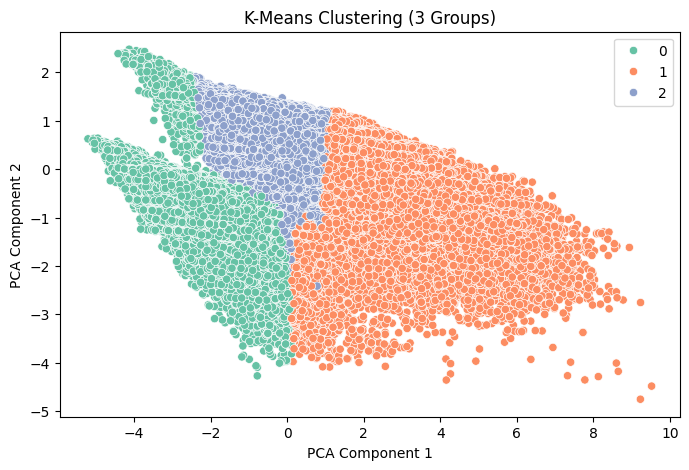

In [6]:
# Clustering lifters into groups based on their lifts
# Standardizing the data so clustering works better

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Drop NaNs from the dataset before clustering
X_cluster = df[['Sex', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]
X_cluster = X_cluster.dropna()  # This ensures no NaNs reach KMeans

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Run KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Reduce the data to 2D so I can plot it
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title("K-Means Clustering (3 Groups)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [7]:
# Create flags for strong squat/bench/deadlift and total performance
# This turns the data into a format usable by Apriori

df_rules = df.copy()
df_rules['SquatHigh'] = df_rules['Best3SquatKg'] > 200
df_rules['BenchHigh'] = df_rules['Best3BenchKg'] > 150
df_rules['DeadliftHigh'] = df_rules['Best3DeadliftKg'] > 250
df_rules['TotalHigh'] = df_rules['TotalKg'] > 600

basket = df_rules[['SquatHigh', 'BenchHigh', 'DeadliftHigh', 'TotalHigh']]

# Run Apriori to find common combinations
frequent = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(frequent, metric="confidence", min_threshold=0.6)

# Show the top rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
0,(BenchHigh),(SquatHigh),0.181323,0.925745,2.859444
1,(DeadliftHigh),(SquatHigh),0.150918,0.960183,2.965817
2,(SquatHigh),(TotalHigh),0.227453,0.702556,3.041288
3,(TotalHigh),(SquatHigh),0.227453,0.984617,3.041288
4,(BenchHigh),(DeadliftHigh),0.121525,0.620447,3.947474
5,(DeadliftHigh),(BenchHigh),0.121525,0.773179,3.947474
6,(BenchHigh),(TotalHigh),0.175682,0.896946,3.882783
7,(TotalHigh),(BenchHigh),0.175682,0.760508,3.882783
8,(TotalHigh),(DeadliftHigh),0.150721,0.652455,4.151116
9,(DeadliftHigh),(TotalHigh),0.150721,0.958933,4.151116


## Conclusion

This notebook explored classification, clustering, and association rule mining using the OpenPowerlifting dataset.

For classification, I used both a Decision Tree and K-Nearest Neighbors to predict whether a lifter would be considered a "high performer" based on their lift numbers and bodyweight. Both models achieved extremely high accuracy. The Decision Tree reached perfect classification performance with a tuned `max_depth` of 10, and KNN also performed nearly identically. These results confirm that the features used (best squat, bench, deadlift, bodyweight, and sex) are highly predictive of total performance.

For clustering, I used KMeans with PCA to reduce the data to two dimensions. The visual output showed three clear groupings, suggesting that lifters naturally fall into performance-based tiers. These clusters could potentially be aligned with weight classes, experience levels, or competition divisions.

Finally, I applied the Apriori algorithm to identify strong patterns between individual lift milestones and high overall totals. The resulting association rules had very high confidence and lift, especially where combinations of strong squats, benches, and deadlifts were tied to totals above 600kg. These patterns could help coaches or athletes understand which lift combinations most often contribute to elite total performance.
